# Sentiment Analysis of drugs used in treatment for COVID-19

This notebook has the objective of capturing research studies related to a configurable drug and display how many studies have positive, neutral or negative regarding the use of this drug in the treatment for COVID-19.

It uses as a datasouce the [COVID-19 Open Research Dataset Challenge (CORD-19) ](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

CORD-19 is a resource of over 128,000 scholarly articles, including over 59,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. 

## Use of IBM Cloud - Watson Natural Language Understanding
This notebook is also powered by IBM Cloud - [Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding), a cloud native product that uses deep learning to extract metadata from text such as entities, keywords, categories, sentiment, emotion, relations, and syntax. It is used in the notebook for the sentiment analysis.

## Main limitations

[Types of Clinical Study Designs](https://research.library.gsu.edu/c.php?g=115595&p=755213) are crucial when researching for the efficiency of a selected drug. At this moment, this notebook doesn't capture the study design type, so a case study will have the same weight as a randomized controlled trial. I tried to capture this information from the papers during some experiments using [BERT QA](https://pypi.org/project/bert-qa/), but without success.

Altough rare, somestimes the sentiment analysis AI will find multiple values for the reseach drug. I'm just considering the first one.

## Acknowledgements
I reused and modified a lot of public available code from [Ken Miller](https://http://machinelearningconsultant.com/) and like any other developer in the world, various snippets from [Stack Overflow](http://stackoverflow.com/)



# Define the drug

In [68]:
#Here you define the drug you will search for
#examples: 
#research_drug='hydroxychloroquine'
##research_drug='remdesivir'
#research_drug='lopinavir'
#research_drug='ritonavir'
#research_drug='ribavirin'
#research_drug='naproxen'
#research_drug='clarithromycin'
research_drug='azithromycin'


# Import required libraries and prepare the environment

In [23]:
import pandas as pd
import numpy as np
import functools
import re
import os
import json
from pprint import pprint
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Add IBM Watson Natural Language Understanding

In [3]:
!pip install --upgrade "ibm-watson>=4.4.0"

from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, KeywordsOptions

     |████████████████████████████████| 366 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 9.0 MB/s eta 0:00:01
  Created wheel for ibm-watson: filename=ibm_watson-4.4.1-py3-none-any.whl size=360493 sha256=154c5c35c33e876ecf44af8315bfc846bfb9a414aa643919a4f2bbc1378c41cf
  Stored in directory: /root/.cache/pip/wheels/ce/e9/3f/8af0576c7d1d4380015d5053618977aba481a67ffbf191ed7f
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-1.5.1-py3-none-any.whl size=44569 sha256=3bc90d34d54680c33f8255690b031583c2cd379d3d20d0e7f53c3de8bab52d86
  Stored in directory: /root/.cache/pip/wheels/51/37/f5/0532ca77cb49d7405e309bb16e3bf3fd4488baabf0f326c63d
Successfully built ibm-watson ibm-cloud-sdk-core
ERROR: kubernetes 10.1.0 has requirement pyyaml~=3.12, but you'll have pyyaml 5.3.1 which is incompatible.
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 0.57.0
    Uninstalling websocket-client-0.57.0:
      Successfully un

# Define auxiliary functions and read the papers

In [69]:
def extract_research_drug(text,word):
    text=text.replace('covid-19','')
    text=text.lower()
    extract=''
    res=''
    try:
        re.search(word, text).group(0)
    except:
        # not found, return extract=null
        return extract
    
    res = [i.start() for i in re.finditer(word, text)]
    for result in res:
        extracted=text[result:result+200]
        extract=extract+' '+extracted
        if extract==' ':
            extract=''
    return extract  
    


def extract_conclusion(text,word):
    text=text.replace('covid-19','')
    text=text.lower()
    extract=''
    res=''
    try:
        re.search(word, text).group(0)
        res = [i.start() for i in re.finditer(word, text)]
        for result in res:
            extracted=text[result:result+200]
            extract=extract+' '+extracted
    except:
        # not found, return extract=null
        return extract
    return extract  
    
    
# keep only documents with covid -cov-2 and cov2
def search_focus(df):
    dfa = df[df['abstract'].str.contains('covid')]
    dfb = df[df['abstract'].str.contains('-cov-2')]
    dfc = df[df['abstract'].str.contains('cov2')]
    dfd = df[df['abstract'].str.contains('ncov')]
    frames=[dfa,dfb,dfc,dfd]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df

# load the meta data from the CSV file
df=pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')
print ('ALL CORD19 articles',df.shape)

#fill na fields
df=df.fillna('no data provided')

#clean the abstract column so the filler 'do data provided'doesn't mess up with the real text later
df.abstract[df.abstract == 'no data provided'] = '' 

#drop duplicate titles
df = df.drop_duplicates(subset='title', keep="first")
#keep only 2020 dated papers
df=df[df['publish_time'].str.contains('2020')]
# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()+df["title"].str.lower()
df=search_focus(df)
print ('Keep only COVID-19 related articles',df.shape)
#define new column to host a snippet from the research paper related to the selected drug
df['paper'] = ''


import os
import json
from pprint import pprint
from copy import deepcopy
import math


def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

#let's read the research papers 
for index, row in df.iterrows():
    file_fullpath = '/kaggle/input/CORD-19-research-challenge/'+row['pdf_json_files']
    if ';' not in row['sha'] and os.path.exists(file_fullpath)==True:
        with open(file_fullpath) as json_file:
            data=json.load(json_file)
            body=format_body(data['body_text'])
            body=body.replace("\n", " ")
            text=row['abstract']+' '+body.lower()
         
            #paper = research drug related text extracted from the research paper 
            df.loc[index, 'paper'] = extract_research_drug(json.dumps(data['body_text']).lower(), research_drug)
            
#drop columns we don't need anymore    
df=df.drop(['pdf_json_files'], axis=1)
df=df.drop(['sha'], axis=1)
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ALL CORD19 articles (128492, 19)
Keep only COVID-19 related articles (23207, 19)


,cord_uid,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pmc_json_files,url,s2_id,paper
5524,64q3qcjy,PMC,Latest assessment on COVID-19 from the Europea...,10.2807/1560-7917.es.2020.25.8.2002271,PMC7055041,3.21271e+07,cc-by,latest assessment on covid-19 from the europea...,2020-02-27,no data provided,Euro Surveill,no data provided,no data provided,no data provided,no data provided,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,
5560,bd7whqxf,PMC,Updated rapid risk assessment from ECDC on the...,10.2807/1560-7917.es.2020.25.9.2003051,PMC7068166,3.21563e+07,cc-by,updated rapid risk assessment from ecdc on the...,2020-03-05,no data provided,Euro Surveill,no data provided,no data provided,no data provided,no data provided,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,
5593,l3ijkmwy,PMC,Updated rapid risk assessment from ECDC on the...,10.2807/1560-7917.es.2020.25.10.2003121,PMC7078827,3.21839e+07,cc-by,updated rapid risk assessment from ecdc on the...,2020-03-12,no data provided,Euro Surveill,no data provided,no data provided,no data provided,no data provided,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,
7217,88hibsk5,PMC,The impact of COVID-19 on the provision of don...,10.1038/s41409-020-0873-x,PMC7091850,3.22033e+07,no-cc,the impact of covid-19 on the provision of don...,2020-03-23,"Szer, Jeff; Weisdorf, Daniel; Querol, Sergio; ...",Bone Marrow Transplant,no data provided,no data provided,no data provided,document_parses/pmc_json/PMC7091850.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,
8211,8k34ed1o,PMC,Fortbildung in Zeiten von COVID-19,10.1007/s15006-020-0276-3,PMC7100450,3.22219e+07,no-cc,fortbildung in zeiten von covid-19,2020-03-30,no data provided,MMW Fortschr Med,no data provided,no data provided,no data provided,no data provided,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,


# Filter the dataset to focus only in the selected drug

In [70]:
focus=research_drug
df1 = df[df['paper'].str.contains(focus)]


#if paper column is empty, let's replace it with the abstract
#remove lines without papers 
df1['paper'].dropna(how='any',inplace=True)

print(focus,'focused articles',df1.shape)

df1.head()

azithromycin focused articles (274, 18)


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


,cord_uid,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pmc_json_files,url,s2_id,paper
11995,47z9jqzx,PMC,Considerations for Drug Interactions on QTc in...,10.1016/j.jacc.2020.04.016,PMC7151241,3.22831e+07,no-cc,considerations for drug interactions on qtc in...,2020-04-10,"Roden, Dan M.; Harrington, Robert A.; Poppas, ...",J Am Coll Cardiol,no data provided,no data provided,no data provided,no data provided,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,azithromycin have been touted for potential p...
13877,bisheysk,PMC,COVID-19: an update on diagnostic and therapeu...,10.5483/bmbrep.2020.53.4.080,PMC7196187,3.23363e+07,cc-by-nc,the unexpected pandemic set off by the novel c...,2020-04-30,"Iyer, Mahalaxmi; Jayaramayya, Kaavya; Subraman...",BMB Rep,no data provided,no data provided,no data provided,document_parses/pmc_json/PMC7196187.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,azithromycin has been suggested to act in com...
20563,lftmm6ar,PMC,Multi-lead QT Screening is Necessary for QT Me...,10.1016/j.jacep.2020.04.001,PMC7141442,no data provided,no-cc,multi-lead qt screening is necessary for qt me...,2020-04-07,"Cheung, Christopher C.; Davies, Brianna; Gibbs...",JACC Clin Electrophysiol,no data provided,no data provided,no data provided,no data provided,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,azithromycin.(1) with the increasing availabi...
23459,1nv94c6n,PMC,All about COVID-19 in brief,10.1016/j.nmni.2020.100678,PMC7171515,no data provided,cc-by-nc-nd,all about covid-19 in brief,2020-04-13,"Naserghandi, A.; Allameh, S.F.; Saffarpour, R.",New Microbes New Infect,no data provided,no data provided,no data provided,document_parses/pmc_json/PMC7171515.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,"azithromycin may have a positive effect, espe..."
23514,3cicg45e,PMC,Effective Use of Angiotensin II in Coronavirus...,10.1213/xaa.0000000000001221,PMC7172437,no data provided,no-cc,the rapid spread of coronavirus disease 2019 (...,2020-04-16,"Bobeck, Kevin A.; Holtzclaw, Arthur W.; Brown,...",A A Pract,no data provided,no data provided,no data provided,document_parses/pmc_json/PMC7172437.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,no data provided,azithromycin and started on a continuous hepa...


# Build Results Dataframe
We are going to build a results dataframe containing:
- date
- study description
- link to the paper
- abstract
- snippets from the research paper
- source
- journal
- cord_uid

In [71]:

def extract_design(text,word):
    text=text.replace('covid-19','')
    extract=''
    res=''
    if word in text:
        res = [i.start() for i in re.finditer(word, text)]
    if res=='':
        word='study'
        res = [i.start() for i in re.finditer(word,text)]
    for result in res:
        extracted=text[result-400:result+400]
        #print (extracted1)
        extract=extract+' '+extracted
    #print (extract)
    return extract



#Create the Results Dataframe, sorted by date
df_results = pd.DataFrame(columns=['date','study','link','abstract','paper','source_x','journal','cord_uid'])

for index, row in df1.iterrows():
    abstract=df1.loc[index, 'abstract']
    paper=df1.loc[index, 'paper']
    #add link
    link=row['doi']
    linka='https://doi.org/'+link

    to_append = [row['publish_time'],row['title'],linka,abstract,paper,row['source_x'],row['journal'],row['cord_uid']]
    df_length = len(df_results)
    df_results.loc[df_length] = to_append
    

df_results=df_results.sort_values(by=['date'], ascending=False)
df_results.head()

,date,study,link,abstract,paper,source_x,journal,cord_uid
242,2020-06-30,Clinical features of pediatric patients with c...,https://doi.org/10.1016/j.jcv.2020.104377,abstract background coronavirus disease 2019 (...,"azithromycin (oral/intravenous infusion, once...",Elsevier; Medline; PMC; WHO,Journal of Clinical Virology,53xjbu8i
140,2020-05-31,Médicaments rhumatologiques pour le traitement...,https://doi.org/10.1016/j.rhum.2020.03.010,médicaments rhumatologiques pour le traitement...,azithromycine \u00e0 l' hcq permettait de r\u...,Elsevier; Medline; PMC; WHO,Revue du Rhumatisme,hck0sow6
32,2020-05-16,Encephalopathy and seizure activity in a COVID...,https://doi.org/10.1016/j.idcr.2020.e00814,abstract a 41-year-old male with a history of ...,azithromycin 500 mg once followed by 250 mg d...,Elsevier,no data provided,gkes9a16
57,2020-05-16,Safety considerations of chloroquine and hydro...,https://doi.org/10.1016/j.cmi.2020.05.006,summary chloroquine and hydroxychloroquine are...,"azithromycin [7] ."", ""cite_spans"": [{""start"":...",Elsevier,no data provided,b5fel2d3
41,2020-05-16,"COVID-19 in Spain: age, Interleukin-6, C React...",https://doi.org/10.1101/2020.05.13.20101345,sars-cov-2 infection has widely spread to the ...,azithromycin combinations (71.3%); those trea...,MedRxiv,no data provided,c59bmn5f


# Sentiment Analysis using AI - IBM Watson Natural Language Understanding

## Authentication key

In [7]:
#You can get one for free at https://www.ibm.com/watson/natural-language-processing
apikey=''
url=''

Depending on the number of research papers, this can take a while

In [72]:
#Authenticate
authenticator = IAMAuthenticator(apikey)
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator=authenticator
)

natural_language_understanding.set_service_url(url)

#create two new columns - score and sentiment, which will have the values returned from the AI
df_results['score'] = np.nan
df_results['sentiment'] = np.nan

#reset index to zero
df_results.reset_index(drop=True, inplace=True)


for index, row in df_results.iterrows():
    try:
        #call the API
        response = natural_language_understanding.analyze(
            text=row['paper'],
            features=Features(keywords=KeywordsOptions(sentiment=True,emotion=False,limit=100))).get_result()
    except:
        #error, probably unsupported language, jump to the next one
        next
        
    for i in response['keywords']:
        if research_drug in i['text']:
            #found it, set the values and skip to the next row
            score = i['sentiment']['score']
            sentiment = i['sentiment']['label']
            df_results['score'][index] = score
            df_results['sentiment'][index] = sentiment
            break


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Let's check the Dataframe head with the scores and sentiment

In [73]:
df_results.head()

,date,study,link,abstract,paper,source_x,journal,cord_uid,score,sentiment
0,2020-06-30,Clinical features of pediatric patients with c...,https://doi.org/10.1016/j.jcv.2020.104377,abstract background coronavirus disease 2019 (...,"azithromycin (oral/intravenous infusion, once...",Elsevier; Medline; PMC; WHO,Journal of Clinical Virology,53xjbu8i,0.0,neutral
1,2020-05-31,Médicaments rhumatologiques pour le traitement...,https://doi.org/10.1016/j.rhum.2020.03.010,médicaments rhumatologiques pour le traitement...,azithromycine \u00e0 l' hcq permettait de r\u...,Elsevier; Medline; PMC; WHO,Revue du Rhumatisme,hck0sow6,0.0,neutral
2,2020-05-16,Encephalopathy and seizure activity in a COVID...,https://doi.org/10.1016/j.idcr.2020.e00814,abstract a 41-year-old male with a history of ...,azithromycin 500 mg once followed by 250 mg d...,Elsevier,no data provided,gkes9a16,0.0,neutral
3,2020-05-16,Safety considerations of chloroquine and hydro...,https://doi.org/10.1016/j.cmi.2020.05.006,summary chloroquine and hydroxychloroquine are...,"azithromycin [7] ."", ""cite_spans"": [{""start"":...",Elsevier,no data provided,b5fel2d3,0.0,neutral
4,2020-05-16,"COVID-19 in Spain: age, Interleukin-6, C React...",https://doi.org/10.1101/2020.05.13.20101345,sars-cov-2 infection has widely spread to the ...,azithromycin combinations (71.3%); those trea...,MedRxiv,no data provided,c59bmn5f,0.0,neutral


## Save to a CSV file for future reference

In [74]:
df_results.to_csv(research_drug+'_sentiment.csv',index=False)

## Sentiment numbers

In [75]:
#remove lines where the AI couldn't capture a score
df_results['score'].dropna(inplace=True)


grouped = df_results.groupby(df_results['sentiment'])

print('Total: ' + str(df_results['score'].size))
grouped['study'].count()

Total: 273


sentiment
negative     71
neutral     180
positive     22
Name: study, dtype: int64

## Let's plot this in a graphic

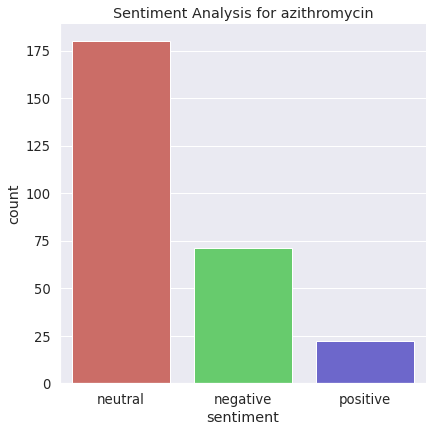

In [76]:
sns.set(style="darkgrid")
sns.set(font_scale=1.2)
sns.catplot(x='sentiment', data=df_results, kind="count", height=6, aspect=1.0, palette="hls")
plt.title('Sentiment Analysis for ' + research_drug)
plt.show();